# Convolutional Neural Networks - CIFAR-10 Image Classification

## Preparations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_dir = '/content/drive/MyDrive/Colab\ Notebooks/AKT/'
safe_dir = '/content/drive/MyDrive/Colab Notebooks/AKT/'
data_dir = base_dir + 'data/'

In [3]:
## library for ml auxilary tools from prof. Bodenhofer
!pip install git+https://github.com/UBod/pyMLaux.git

  Cloning https://github.com/UBod/pyMLaux.git to /tmp/pip-req-build-bg25utp8
  Running command git clone --filter=blob:none --quiet https://github.com/UBod/pyMLaux.git /tmp/pip-req-build-bg25utp8
  Resolved https://github.com/UBod/pyMLaux.git to commit fee8dfb366fcb0bfb9944a7ac714678aeb521c58
  Preparing metadata (setup.py) ... done
  Created wheel for pyMLaux: filename=pyMLaux-0.0.7-py3-none-any.whl size=6830 sha256=0ead2fa73a4d8e88f049b1e82c324100a17604b79ac235aaab00a764cce6f8fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-5kd5siy0/wheels/53/7c/8e/707f45969871484f44ca858446dfdb44bc59698484796806c1
Successfully built pyMLaux


In [4]:
import os, shutil
import random
import sys
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from pyMLaux import show_img_data, plot_history, evaluate_classification_result

In [5]:
## unzip data to local directory on Colab runtime
## This is faster than working with the files from google drive
##%%capture
!cd ~; unzip -n $data_dir/train.zip; unzip -n $data_dir/test.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: train/cat.1898.jpg      
  inflating: train/cat.1899.jpg      
  inflating: train/cat.19.jpg        
  inflating: train/cat.190.jpg       
  inflating: train/cat.1900.jpg      
  inflating: train/cat.1901.jpg      
  inflating: train/cat.1902.jpg      
  inflating: train/cat.1903.jpg      
  inflating: train/cat.1904.jpg      
  inflating: train/cat.1905.jpg      
  inflating: train/cat.1906.jpg      
  inflating: train/cat.1907.jpg      
  inflating: train/cat.1908.jpg      
  inflating: train/cat.1909.jpg      
  inflating: train/cat.191.jpg       
  inflating: train/cat.1910.jpg      
  inflating: train/cat.1911.jpg      
  inflating: train/cat.1912.jpg      
  inflating: train/cat.1913.jpg      
  inflating: train/cat.1914.jpg      
  inflating: train/cat.1915.jpg      
  inflating: train/cat.1916.jpg      
  inflating: train/cat.1917.jpg      
  inflating: train/cat.1918.jpg      
  inflating: train/ca

In [6]:
train_data_dir = os.path.expanduser('~/train/')
test_data_dir = os.path.expanduser('~/test/')

In [7]:
## Preprocessing of the data

##convert from text to binary label
def convert_category(category):
    return int(category == 'dog')

def preprocess_data(path):
    X = []
    y  =[]
    for p in os.listdir(path):
        ## file names are in form of category.number.fileextension so we can extract the label by splitting at the first .
        category = p.split(".")[0]
        category = convert_category(category)
        ## convert to graysclae 80, 80 picture for simplicity
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)

    return np.array(X), np.array(y)

In [8]:
train_X, train_y = preprocess_data(train_data_dir)
test_X, test_y = preprocess_data(test_data_dir)

## reshape data for CNN use
train_X = train_X.reshape(-1, 80,80,1)
test_X = test_X.reshape(-1, 80,80,1)

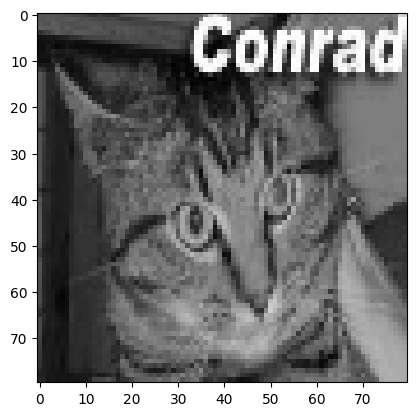

In [9]:
## show sample
plt.imshow(train_X[0],cmap='gray')

In [10]:
## Number of images in dataset. The data set is fairly balanced.
train_X.shape[:1], test_X.shape[:1]

((5379,), (616,))

In [11]:
## I had problems when shuffling the data with the image_generator therefore I am shuffling it here.
train_X, train_y = shuffle(train_X, train_y)
test_X, test_y = shuffle(test_X, test_y)

## Configure Generators

In [12]:
batch_size = 32
img_size = (80, 80)

## since the dataset is only split into training and test I split the training into training and validation.
## I apply some data augmentations. I do not flip vertically because classifying upside down dogs is not the goal. The images are filled with black pixels if the augmentation lead to undefined pixels in the image.
## I also rescale so the values are between 0 and 1 instead of 0 and 255
train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   validation_split=0.1,
                                   fill_mode='constant',
                                   cval=0)

train_generator = train_datagen.flow(x=train_X,
                                    y=train_y,
                                    batch_size=batch_size,
                                    subset='training',
                                     shuffle=False)

## the test data is only rescaled
test_datagen = ImageDataGenerator(rescale=(1. / 255))


validation_generator = train_datagen.flow(train_X,
                                          train_y,
                                          batch_size=batch_size,
                                          subset='validation',
                                          shuffle=False)

test_generator = test_datagen.flow(test_X,
                                   test_y,
                                  batch_size=batch_size,
                                  shuffle=False)

## Experiments

**Experiment Design**

I want to experiment with:

1. different number of neurons the CNN layers. Specifically one where the number of neurons per layer goes up and one where it goes down.
I would expect CNN where the number of neurons goes up to perform better since there less low level features and more high level features.
2. different Pooling methods. I will take the best network from 1. and try it with different Pooling sizes and both avgPooling and maxPooling.
I expect maxPooling with a rather small Pooling size to perform the best since the images are rather small to begin with and it makes more sense to take the maximum since it is more about if the feature is present at all and less about the feature being present over a larger area (which avgPooling would favor)
3. skip connections. I will take the best network from 2. and add skip connections.
I dont think that skip connections will yield a better result since the task at hand is rather basic.


## 1. Different number of neurons in the CNN layers

In [ ]:
model_low_to_high = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), input_shape=(img_size[0], img_size[1], 1),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(16, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    ## Use sigmoid in the output layer since the problem is a binary classification problem. This will give us a number between 0 and 1 telling us if the network leans more towards cat or dog
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model_low_to_high.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_low_to_high.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_174 (Conv2D)         (None, 80, 80, 16)        144       
                                                                 
 batch_normalization_200 (B  (None, 80, 80, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_200 (Activation  (None, 80, 80, 16)        0         
 )                                                               
                                                                 
 conv2d_175 (Conv2D)         (None, 80, 80, 16)        2304      
                                                                 
 batch_normalization_201 (B  (None, 80, 80, 16)        64        
 atchNormalization)                                              
                                                     

In [ ]:
## Training the model. I also save the model every time it is better than the previous best
filepath = safe_dir + 'CNN_{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_low_high = model_low_to_high.fit(train_generator, epochs=25,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
151/152 [============================>.] - ETA: 0s - loss: 0.6441 - accuracy: 0.6416
Epoch 1: val_accuracy improved from -inf to 0.54190, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_01-0.5419.hdf5
152/152 [==============================] - 8s 32ms/step - loss: 0.6442 - accuracy: 0.6421 - val_loss: 0.9013 - val_accuracy: 0.5419
Epoch 2/25
  1/152 [..............................] - ETA: 6s - loss: 0.4678 - accuracy: 0.8125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/152 [============================>.] - ETA: 0s - loss: 0.5578 - accuracy: 0.7139
Epoch 2: val_accuracy improved from 0.54190 to 0.55121, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_02-0.5512.hdf5
152/152 [==============================] - 7s 44ms/step - loss: 0.5589 - accuracy: 0.7123 - val_loss: 0.7785 - val_accuracy: 0.5512
Epoch 3/25
152/152 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7534
Epoch 3: val_accuracy improved from 0.55121 to 0.58101, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_03-0.5810.hdf5
152/152 [==============================] - 6s 40ms/step - loss: 0.5042 - accuracy: 0.7534 - val_loss: 0.7304 - val_accuracy: 0.5810
Epoch 4/25
151/152 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.7875
Epoch 4: val_accuracy improved from 0.58101 to 0.74302, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_04-0.7430.hdf5
152/152 [==============================] - 10s 65ms/step 

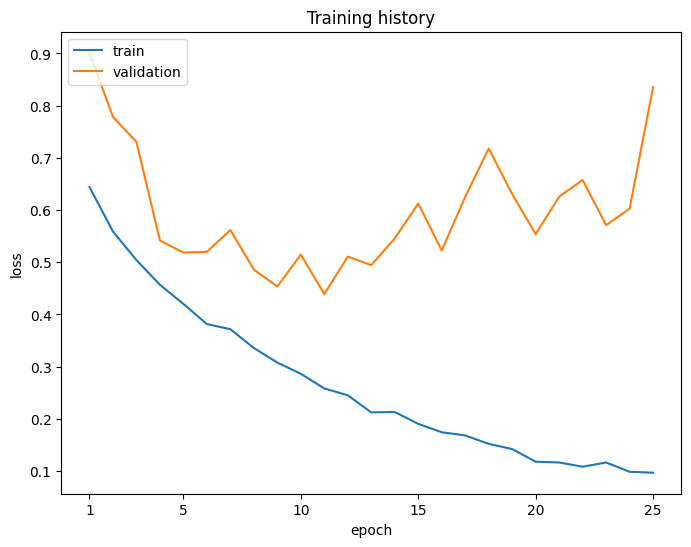

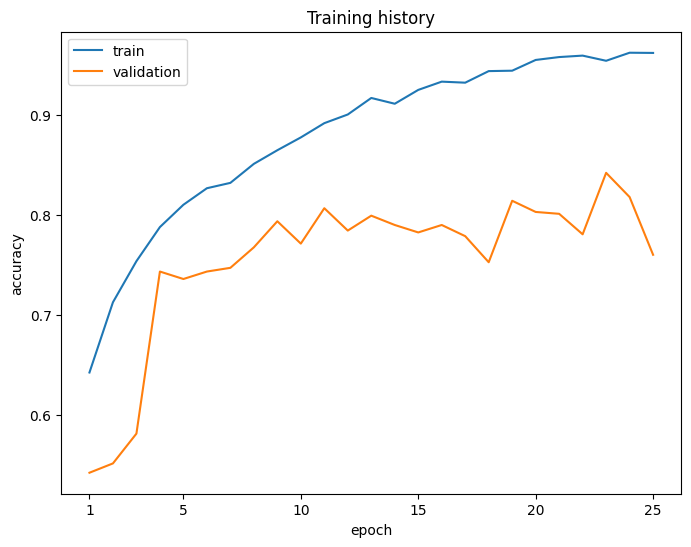

In [ ]:
## handy tool provided by pyMLaux
## we can see some overfitting as the training loss and accuracy constantly improve while the validation metrics take a few negative peaks and stop improving after about 10 epochs.
## This is a clear sign of the model overfitting to the training data. It might me due to the network being to big for this task. However I thought things like dropout would stop massive overfitting.
plot_history(history_low_high)

In [ ]:
## second model with number of neurons decreasing per level
model_high_to_low = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(img_size[0], img_size[1], 1),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Conv2D(16, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(16, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model_high_to_low.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_high_to_low.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_180 (Conv2D)         (None, 80, 80, 64)        576       
                                                                 
 batch_normalization_207 (B  (None, 80, 80, 64)        256       
 atchNormalization)                                              
                                                                 
 activation_207 (Activation  (None, 80, 80, 64)        0         
 )                                                               
                                                                 
 conv2d_181 (Conv2D)         (None, 80, 80, 64)        36864     
                                                                 
 batch_normalization_208 (B  (None, 80, 80, 64)        256       
 atchNormalization)                                              
                                                     

In [ ]:
filepath = safe_dir + 'CNN_High_Low_{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_high_low = model_high_to_low.fit(train_generator, epochs=25,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
152/152 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.6072
Epoch 1: val_accuracy improved from -inf to 0.54190, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_High_Low_01-0.5419.hdf5
152/152 [==============================] - 10s 45ms/step - loss: 0.6649 - accuracy: 0.6072 - val_loss: 0.6926 - val_accuracy: 0.5419
Epoch 2/25
152/152 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6532
Epoch 2: val_accuracy did not improve from 0.54190
152/152 [==============================] - 5s 33ms/step - loss: 0.6277 - accuracy: 0.6532 - val_loss: 0.7423 - val_accuracy: 0.5419
Epoch 3/25
151/152 [============================>.] - ETA: 0s - loss: 0.5898 - accuracy: 0.6896
Epoch 3: val_accuracy improved from 0.54190 to 0.55121, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_High_Low_03-0.5512.hdf5
152/152 [==============================] - 7s 45ms/step - loss: 0.5892 - accuracy: 0.6898 - val_loss: 0.7096 - va

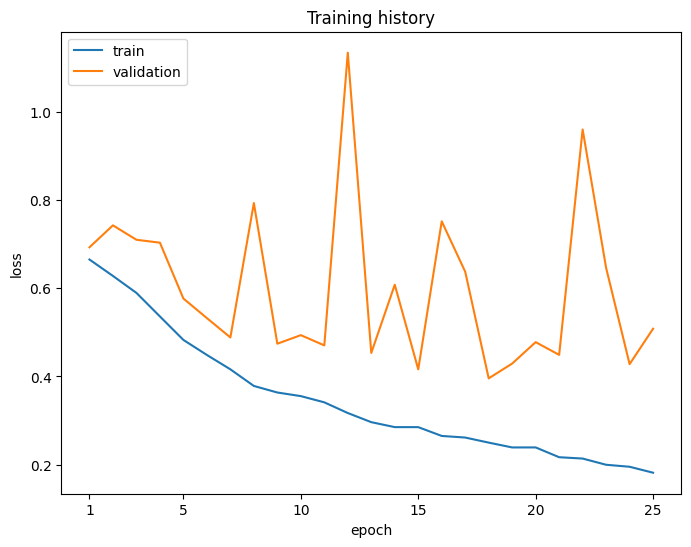

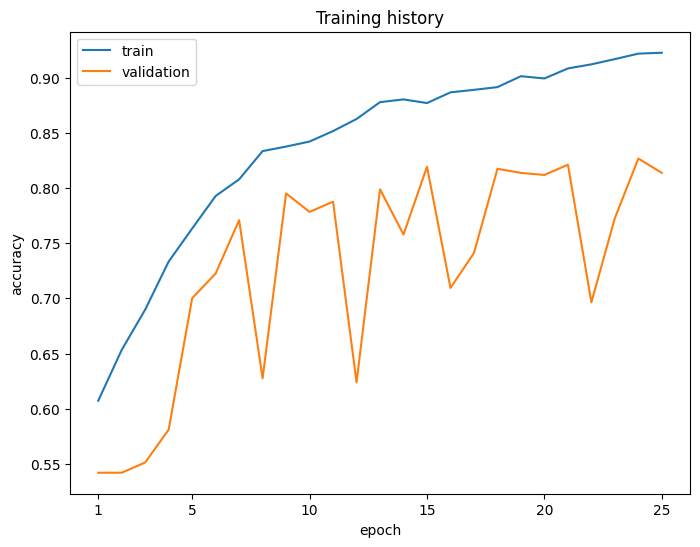

In [ ]:
## While the result on the validation data is very similar to model 1 the performance on the trainingdata is not as good.
## So overall there is less overfitting but a similar result on the validation data
plot_history(history_high_low)

In [27]:
## load the best model that was saved, since the default is just the model of the last epoch.
model_low_to_high = tf.keras.models.load_model(safe_dir + 'CNN_23-0.8417.hdf5')
model_high_to_low = tf.keras.models.load_model(safe_dir + 'CNN_High_Low_24-0.8268.hdf5')

In [28]:
pred_low_high = model_low_to_high.predict(validation_generator)

17/17 [==============================] - 1s 23ms/step


In [30]:
pred_high_low = model_high_to_low.predict(validation_generator)

17/17 [==============================] - 1s 41ms/step


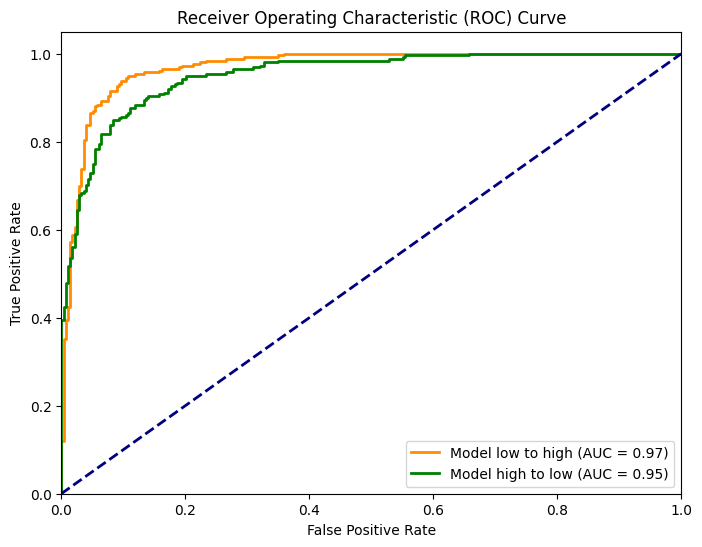

In [31]:
# Plot ROC curves for both models. A positive is a dog.
# In the plot we see that the low to high model does perform slightly better as expected
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(validation_generator.y, pred_low_high)
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(validation_generator.y, pred_high_low)

# Compute Area Under the Curve (AUC) for both models
roc_auc_model1 = auc(fpr_model1, tpr_model1)
roc_auc_model2 = auc(fpr_model2, tpr_model2)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='darkorange', lw=2, label=f'Model low to high (AUC = {roc_auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, color='green', lw=2, label=f'Model high to low (AUC = {roc_auc_model2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

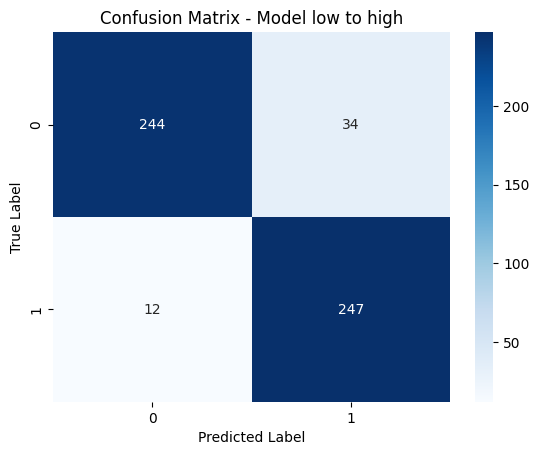

In [32]:
## Confusion matrix for model low to high
## We see that the confusion matrix is somewhat balanced however more cats are mislabeled as dogs than the other way around
conf_matrix_model1 = confusion_matrix(validation_generator.y, (pred_low_high > 0.5).astype(int))
class_labels = unique_labels(validation_generator.y, (pred_low_high > 0.5).astype(int))

sns.heatmap(conf_matrix_model1, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Model low to high')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 2. Different Pooling Layers

In [13]:
## first model is identical to the low_high model but uses avgPooling
model_avg_pool = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), input_shape=(img_size[0], img_size[1], 1),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(16, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.AvgPool2D((3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.AvgPool2D((3, 3)),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.AvgPool2D((3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model_avg_pool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model_avg_pool.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        144       
                                                                 
 batch_normalization (Batch  (None, 80, 80, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 80, 80, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        2304      
                                                                 
 batch_normalization_1 (Bat  (None, 80, 80, 16)        64        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 80, 80, 16)        0

In [15]:
filepath = safe_dir + 'CNN_avg_Pool{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_avg_pool = model_avg_pool.fit(train_generator, epochs=25,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
151/152 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.6187
Epoch 1: val_accuracy improved from -inf to 0.47858, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_avg_Pool01-0.4786.hdf5
152/152 [==============================] - 15s 38ms/step - loss: 0.6625 - accuracy: 0.6188 - val_loss: 0.6978 - val_accuracy: 0.4786
Epoch 2/25
  1/152 [..............................] - ETA: 7s - loss: 0.6504 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


152/152 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.6760
Epoch 2: val_accuracy improved from 0.47858 to 0.52328, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_avg_Pool02-0.5233.hdf5
152/152 [==============================] - 7s 45ms/step - loss: 0.5994 - accuracy: 0.6760 - val_loss: 0.9801 - val_accuracy: 0.5233
Epoch 3/25
152/152 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7175
Epoch 3: val_accuracy did not improve from 0.52328
152/152 [==============================] - 5s 31ms/step - loss: 0.5474 - accuracy: 0.7175 - val_loss: 1.3206 - val_accuracy: 0.5177
Epoch 4/25
151/152 [============================>.] - ETA: 0s - loss: 0.5053 - accuracy: 0.7474
Epoch 4: val_accuracy improved from 0.52328 to 0.63501, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_avg_Pool04-0.6350.hdf5
152/152 [==============================] - 6s 40ms/step - loss: 0.5054 - accuracy: 0.7474 - val_loss: 0.7247 - val_accuracy:

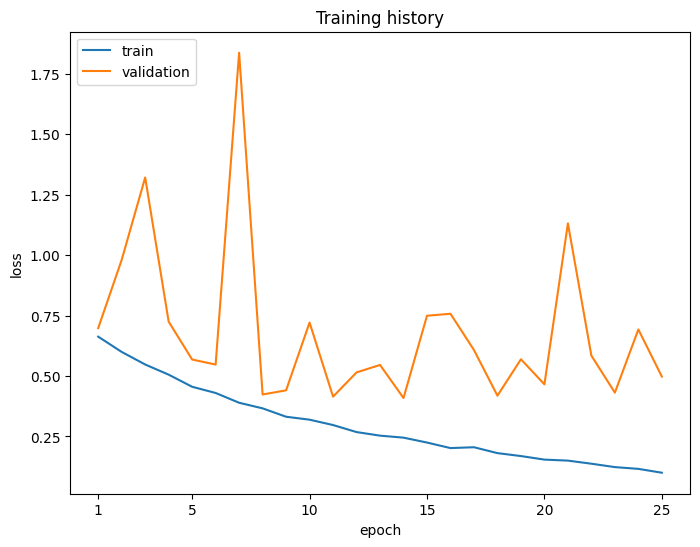

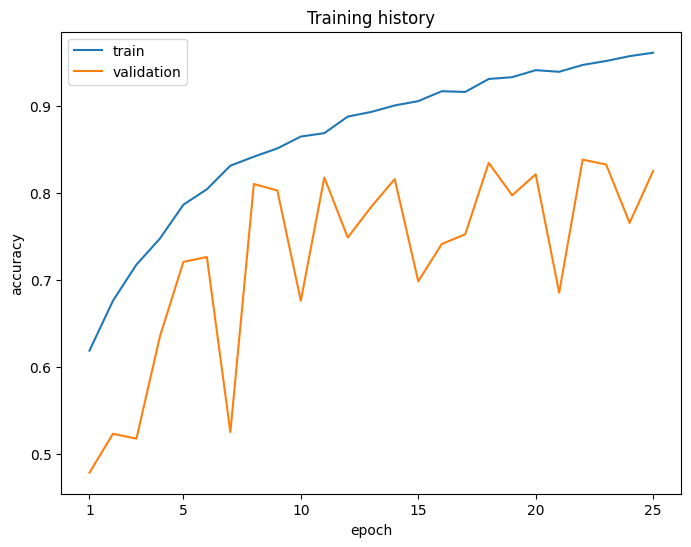

In [16]:
## again we see very similar results with the accuracy reaching about 80 % on the validation data as well as the model overfitting on the training data.
## avg pool does not perform worse contradictory to my assumption.
plot_history(history_avg_pool)

In [19]:
## second model uses maxPooling but with a higher kernel
model_high_max_pool = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), input_shape=(img_size[0], img_size[1], 1),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(16, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((4, 4)),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((4, 4)),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((4, 4)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model_high_max_pool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model_high_max_pool.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 80, 80, 16)        144       
                                                                 
 batch_normalization_21 (Ba  (None, 80, 80, 16)        64        
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 80, 80, 16)        2304      
                                                                 
 batch_normalization_22 (Ba  (None, 80, 80, 16)        64        
 tchNormalization)                                               
                                                                 
 activation_22 (Activation)  (None, 80, 80, 16)       

In [21]:
filepath = safe_dir + 'CNN_High_max_pool_{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_high_max_pool = model_high_max_pool.fit(train_generator, epochs=25,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
151/152 [============================>.] - ETA: 0s - loss: 0.6492 - accuracy: 0.6320
Epoch 1: val_accuracy improved from -inf to 0.51769, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_High_max_pool_01-0.5177.hdf5
152/152 [==============================] - 13s 54ms/step - loss: 0.6487 - accuracy: 0.6328 - val_loss: 0.7228 - val_accuracy: 0.5177
Epoch 2/25
151/152 [============================>.] - ETA: 0s - loss: 0.5770 - accuracy: 0.7008
Epoch 2: val_accuracy did not improve from 0.51769
152/152 [==============================] - 8s 52ms/step - loss: 0.5779 - accuracy: 0.7003 - val_loss: 0.8373 - val_accuracy: 0.5177
Epoch 3/25
152/152 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7377
Epoch 3: val_accuracy improved from 0.51769 to 0.70205, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_High_max_pool_03-0.7020.hdf5
152/152 [==============================] - 6s 42ms/step - loss: 0.5258 - accuracy: 0.7377 - val_loss: 0

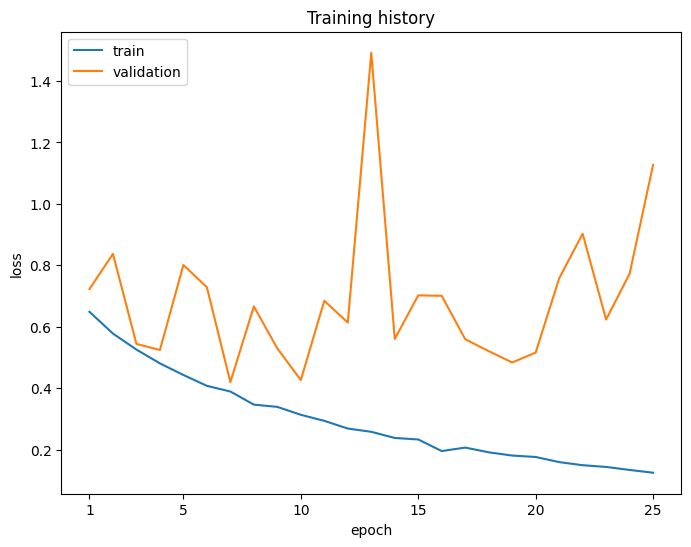

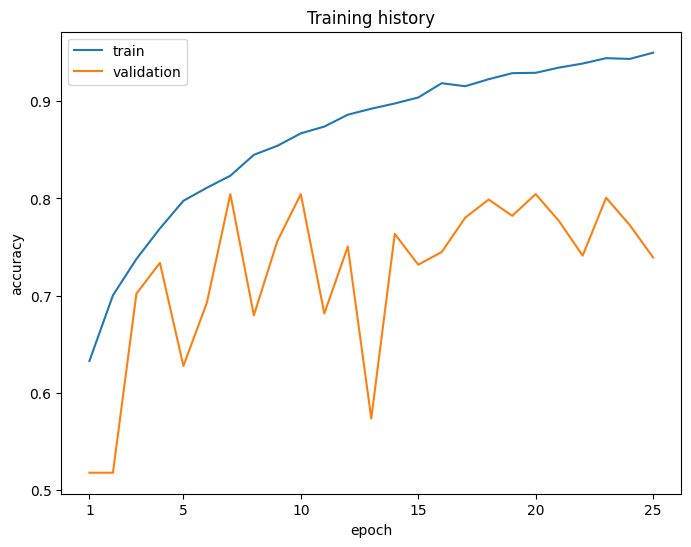

In [22]:
## Max Pooling performs slightly worse than avg Pool on both the training and the validation data
plot_history(history_high_max_pool)

In [23]:
## load the best model that was saved, since the default is just the model of the last epoch.
model_avg_pool = tf.keras.models.load_model(safe_dir + 'CNN_avg_Pool22-0.8380.hdf5')
model_high_max_pool = tf.keras.models.load_model(safe_dir + 'CNN_High_max_pool_07-0.8045.hdf5')

In [24]:
pred_avg_pool = model_avg_pool.predict(validation_generator)

17/17 [==============================] - 1s 22ms/step


In [25]:
pred_high_max_pool = model_high_max_pool.predict(validation_generator)

17/17 [==============================] - 1s 22ms/step


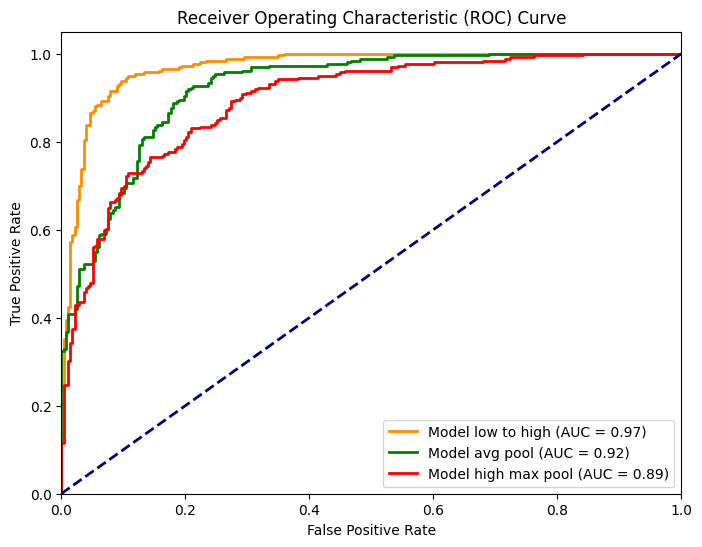

In [33]:
# Plot ROC curves for both models and the best model from experiment 1. A positive is a dog.
# In the plot we see that both models perform significantly worse than the "standard" low to high model from experiment 1 as expected.
# However avg Pooling actually performs better than a high max Pooling Kernel which was not expected
fpr_model3, tpr_model3, thresholds_model3 = roc_curve(validation_generator.y, pred_avg_pool)
fpr_model4, tpr_model4, thresholds_model4 = roc_curve(validation_generator.y, pred_high_max_pool)

# Compute Area Under the Curve (AUC) for both models
roc_auc_model3 = auc(fpr_model3, tpr_model3)
roc_auc_model4 = auc(fpr_model4, tpr_model4)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='darkorange', lw=2, label=f'Model low to high (AUC = {roc_auc_model1:.2f})')
plt.plot(fpr_model3, tpr_model3, color='green', lw=2, label=f'Model avg pool (AUC = {roc_auc_model3:.2f})')
plt.plot(fpr_model4, tpr_model4, color='red', lw=2, label=f'Model high max pool (AUC = {roc_auc_model4:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

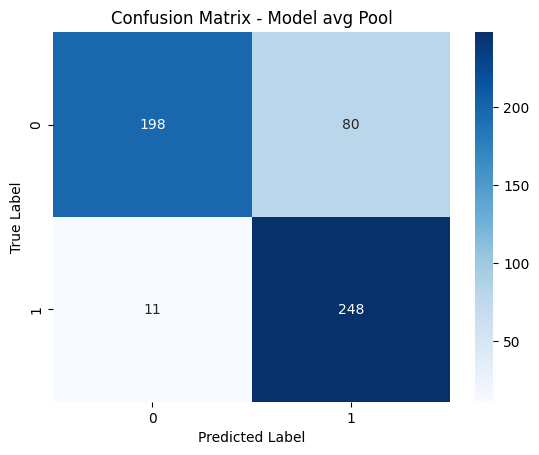

In [73]:
## We see in the confusion matrix that the avg Pooling model missclassifies even more cats as dogs.
conf_matrix_model3 = confusion_matrix(validation_generator.y, (pred_avg_pool > 0.5).astype(int))
class_labels = unique_labels(validation_generator.y, (pred_avg_pool > 0.5).astype(int))

sns.heatmap(conf_matrix_model3, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Model avg Pool')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 3. Network with added skip connections

In [54]:
## model with a few added skip connections.
## due to the skip connections we have to maintain the same shape and therefore cant use different number of neurons per layers and cant use maxPooling in the middle blocks.
inputs = tf.keras.Input(shape=(80,80,1))

## Block 1
x = (inputs)
x = tf.keras.layers.Conv2D(32, (3), activation='relu')(x)
block_1_output = tf.keras.layers.MaxPooling2D(3)(x)

## Block 2
x = tf.keras.layers.Conv2D(32, (3), activation='relu', padding='same')(block_1_output)
x = tf.keras.layers.Conv2D(32, (3), activation='relu', padding='same')(x)
block_2_output = tf.keras.layers.add([x, block_1_output])

## Block 3
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(block_1_output)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
block_3_output = tf.keras.layers.add([x, block_2_output])

##
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(block_3_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_skip = tf.keras.Model(inputs, outputs)


model_skip.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
model_skip.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_74 (Conv2D)          (None, 78, 78, 32)           320       ['input_16[0][0]']            
                                                                                                  
 max_pooling2d_23 (MaxPooli  (None, 26, 26, 32)           0         ['conv2d_74[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_75 (Conv2D)          (None, 26, 26, 32)           9248      ['max_pooling2d_23[0][0]']

In [55]:
filepath = safe_dir + 'CNN_skip{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_skip = model_skip.fit(train_generator, epochs=25,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/25
151/152 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.5331
Epoch 1: val_accuracy improved from -inf to 0.51769, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_skip01-0.5177.hdf5
152/152 [==============================] - 11s 49ms/step - loss: 0.6919 - accuracy: 0.5339 - val_loss: 0.6921 - val_accuracy: 0.5177


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/25
152/152 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5351
Epoch 2: val_accuracy improved from 0.51769 to 0.52514, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_skip02-0.5251.hdf5
152/152 [==============================] - 5s 30ms/step - loss: 0.6897 - accuracy: 0.5351 - val_loss: 0.6845 - val_accuracy: 0.5251
Epoch 3/25
152/152 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5556
Epoch 3: val_accuracy improved from 0.52514 to 0.54935, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_skip03-0.5493.hdf5
152/152 [==============================] - 6s 39ms/step - loss: 0.6836 - accuracy: 0.5556 - val_loss: 0.6794 - val_accuracy: 0.5493
Epoch 4/25
152/152 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.5758
Epoch 4: val_accuracy improved from 0.54935 to 0.56797, saving model to /content/drive/MyDrive/Colab Notebooks/AKT/CNN_skip04-0.5680.hdf5
152/152 [=========================

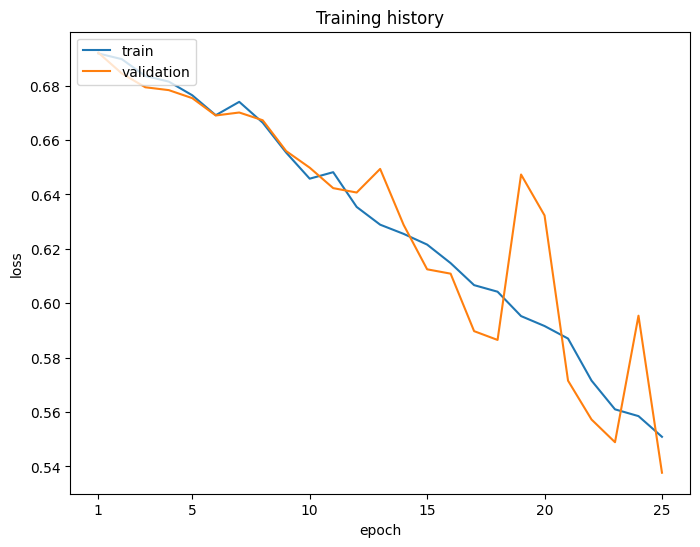

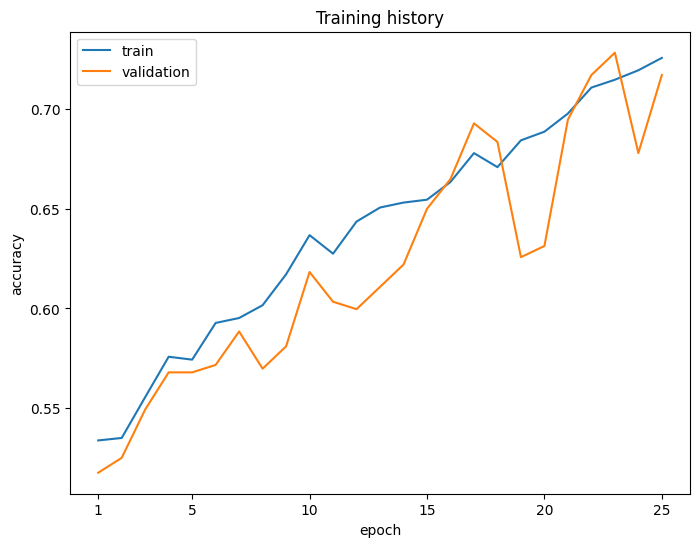

In [58]:
## We see a very different history for the model with skip connections
## The skip connections significantly slowed down the training but also eliminated the overfitting completly.
## While the other models so far reached their peak validation accuracy often as early as epoch 10 this model improved the whole time.
## That said the overall validation accuracy in the end is by far the worst so far. It looks like this is the first model that might have benefited from more epochs.
## It is important to note that these differences might not be due to the skip connections but might be due to the other changes that had to be made to make skip connections possible.
plot_history(history_skip)

In [59]:
## load the best model that was saved, since the default is just the model of the last epoch.
model_skip = tf.keras.models.load_model(safe_dir + 'CNN_skip23-0.7281.hdf5')

In [60]:
pred_skip = model_skip.predict(validation_generator)

17/17 [==============================] - 0s 21ms/step


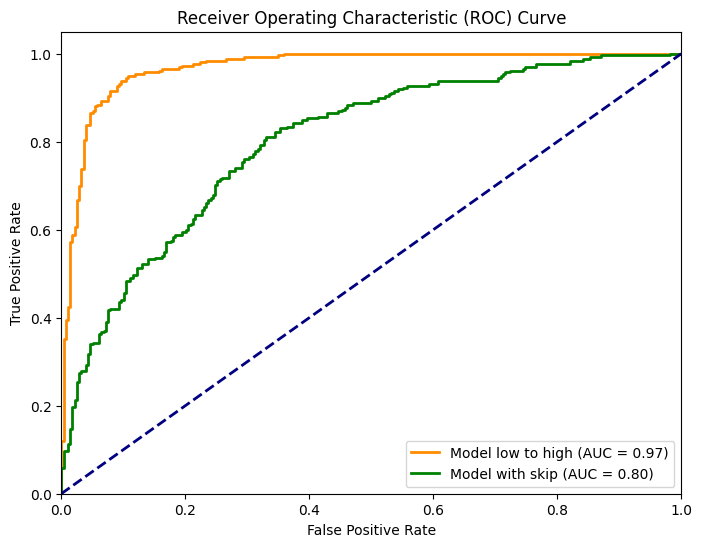

In [70]:
# Plot ROC curves for the skip model and the best model so far the low to high model. A positive is a dog.
# Again we see that the model with skip connections performs far worse than the low to high model
fpr_model5, tpr_model5, thresholds_model5 = roc_curve(validation_generator.y, pred_skip)

# Compute Area Under the Curve (AUC) for both models
roc_auc_model5 = auc(fpr_model5, tpr_model5)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='darkorange', lw=2, label=f'Model low to high (AUC = {roc_auc_model1:.2f})')
plt.plot(fpr_model5, tpr_model5, color='green', lw=2, label=f'Model with skip (AUC = {roc_auc_model5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

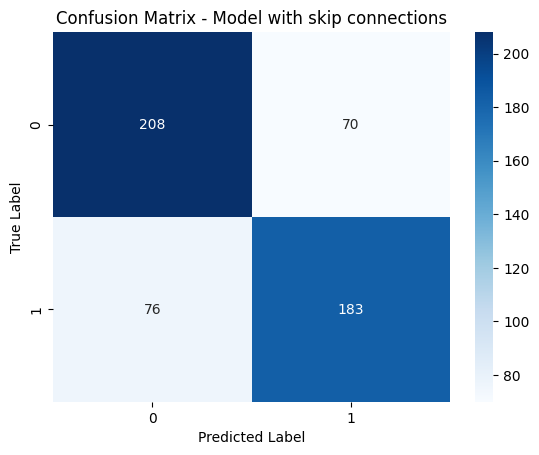

In [72]:
## We see that in contrast to the other models the model with the skip connections does not missclassify more cats than dogs. This might be due to the lower performance overall or due to a better generalization.
conf_matrix_model5 = confusion_matrix(validation_generator.y, (pred_skip > 0.5).astype(int))
class_labels = unique_labels(validation_generator.y, (pred_skip > 0.5).astype(int))

sns.heatmap(conf_matrix_model5, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Model with skip connections')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluate on Test Data (best model)

In [65]:
## save the best model
model_low_to_high.save(safe_dir + 'best_model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
## reload best model
best_model = tf.keras.models.load_model(safe_dir + 'best_model.hdf5')

In [68]:
pred_best = best_model.predict(test_generator)

20/20 [==============================] - 1s 38ms/step


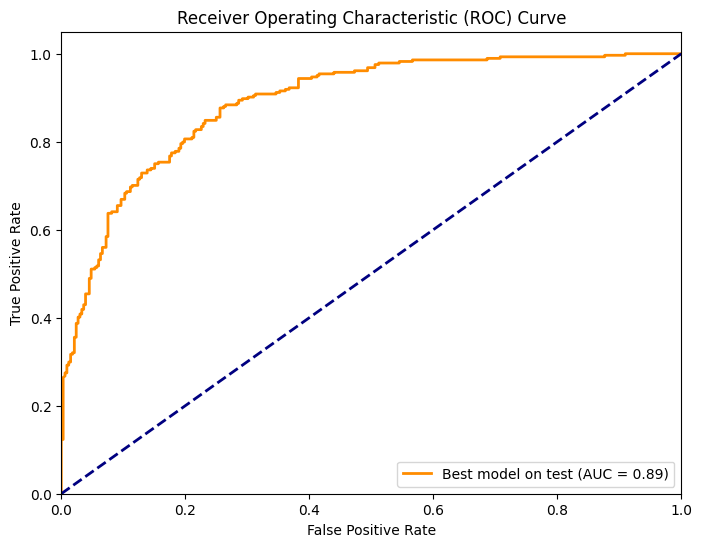

In [71]:
# Plotting the ROC of the best model on the test data we see that it performs significantly worse than on the validation data
fpr_model6, tpr_model6, thresholds_model6 = roc_curve(test_generator.y, pred_best)

# Compute Area Under the Curve (AUC) for both models
roc_auc_model6 = auc(fpr_model6, tpr_model6)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model6, tpr_model6, color='darkorange', lw=2, label=f'Best model on test (AUC = {roc_auc_model6:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

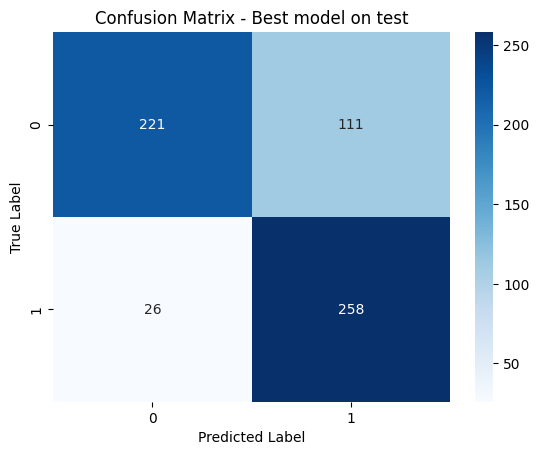

In [74]:
## We see in the confusion matrix the problem that we could already see on the validation data got worse: Many cats are missclassified as dogs.
conf_matrix_model6 = confusion_matrix(test_generator.y, (pred_best > 0.5).astype(int))
class_labels = unique_labels(test_generator.y, (pred_best > 0.5).astype(int))

sns.heatmap(conf_matrix_model6, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Best model on test')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Reflection**

The experiments all got rather similarly bad results given the easy data set.
I think that my "base" architecture was not very well suited for the task.
I should have made a few experiments on a good "base" architecture first before conducting the experiments. The way I did it led to a common bottleneck in all experiments.
The only exception is the model with the skip connections. Here I was forced to change the base architecture and got a different more interesting result.

Also I think I oversimplified the dataset by rescaling it to 80,80 grayscale.
A higher resolution and/or more color channels may have given more distinct results.